In [1]:

# %pip install -q pandas numpy scikit-learn matplotlib imbalanced-learn CHAID

import os
import io
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 200)


In [2]:

public_url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
local_csv = "Telco-Customer-Churn.csv"

def load_data():
    try:
        df = pd.read_csv(public_url)
        print("Loaded data from public URL.")
        return df
    except Exception as e:
        print("Could not load from URL:", e)
        if os.path.exists(local_csv):
            print("Loading local file:", local_csv)
            return pd.read_csv(local_csv)
        else:
            raise FileNotFoundError("Place 'Telco-Customer-Churn.csv' in working directory.")

df = load_data()
df.head()


Loaded data from public URL.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:

display(df.shape)
display(df.dtypes)
df.describe(include='all').T.head(20)


(7043, 21)

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:

df.columns = [c.strip().replace(' ', '_') for c in df.columns]
target_col = "Churn"

if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

if "customerID" in df.columns:
    df = df.drop_duplicates(subset=["customerID"]).reset_index(drop=True)

missing_summary = df.isna().sum().sort_values(ascending=False)
display(missing_summary.head(20))

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

df[target_col] = df[target_col].map({'Yes': 1, 'No': 0}).astype(int)

drop_cols = [c for c in df.columns if c.lower() in ["customerid"]]
df = df.drop(columns=drop_cols)

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

print(f"Numeric cols: {numeric_cols}")
print(f"Categorical cols: {categorical_cols}")


,0
TotalCharges,11
gender,0
SeniorCitizen,0
Partner,0
customerID,0
Dependents,0
tenure,0
MultipleLines,0
PhoneService,0
OnlineSecurity,0


Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical cols: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [5]:

churn_rate = y.mean()
print(f"Overall churn rate: {churn_rate:.3f}")

def plot_category_rate(col):
    tmp = df[[col, target_col]].copy()
    g = tmp.groupby(col)[target_col].mean().sort_values(ascending=False)
    print("\nChurn rate by", col)
    display(g)

for col in categorical_cols[:5]:
    plot_category_rate(col)

for col in numeric_cols[:5]:
    print("\nNumerical summary for", col)
    display(df.groupby(target_col)[col].describe())


Overall churn rate: 0.265

Churn rate by gender


,Churn
gender,
Female,0.269209
Male,0.261603



Churn rate by Partner


,Churn
Partner,
No,0.329580
Yes,0.196649



Churn rate by Dependents


,Churn
Dependents,
No,0.312791
Yes,0.154502



Churn rate by PhoneService


,Churn
PhoneService,
Yes,0.267096
No,0.249267



Churn rate by MultipleLines


,Churn
MultipleLines,
Yes,0.286099
No,0.250442
No phone service,0.249267



Numerical summary for SeniorCitizen


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,5174.0,0.128721,0.334923,0.0,0.0,0.0,0.0,1.0
1,1869.0,0.254682,0.435799,0.0,0.0,0.0,1.0,1.0



Numerical summary for tenure


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
1,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0



Numerical summary for MonthlyCharges


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35



Numerical summary for TotalCharges


,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,5163.0,2555.344141,2329.456984,18.80,577.825,1683.60,4264.125,8672.45
1,1869.0,1531.796094,1890.822994,18.85,134.500,703.55,2331.300,8684.80


In [22]:
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd

X_tree = df.copy()
for col in numeric_cols:
    X_tree[col] = pd.qcut(X_tree[col], q=4, duplicates='drop')
X_tree = pd.get_dummies(X_tree.drop(columns=[target_col]), drop_first=True)

tree_model = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    min_samples_leaf=50,
    random_state=42
)
tree_model.fit(X_tree, y)

print(export_text(tree_model, feature_names=list(X_tree.columns)))


|--- Contract_Two year <= 0.50
|   |--- Contract_One year <= 0.50
|   |   |--- InternetService_Fiber optic <= 0.50
|   |   |   |--- tenure_(9.0, 29.0] <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- tenure_(9.0, 29.0] >  0.50
|   |   |   |   |--- class: 0
|   |   |--- InternetService_Fiber optic >  0.50
|   |   |   |--- TotalCharges_(3794.738, 8684.8] <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- TotalCharges_(3794.738, 8684.8] >  0.50
|   |   |   |   |--- class: 0
|   |--- Contract_One year >  0.50
|   |   |--- StreamingMovies_Yes <= 0.50
|   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |   |--- class: 0
|   |   |--- StreamingMovies_Yes >  0.50
|   |   |   |--- StreamingTV_Yes <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- StreamingTV_Yes >  0.50
|   |   |   |   |--- class: 0
|--- Contract_Two year >  0.50
|   |--- InternetService_Fiber optic <= 0.50
|   |  

✅ Logistic Regression trained successfully
Accuracy: 0.8055
ROC-AUC: 0.8419


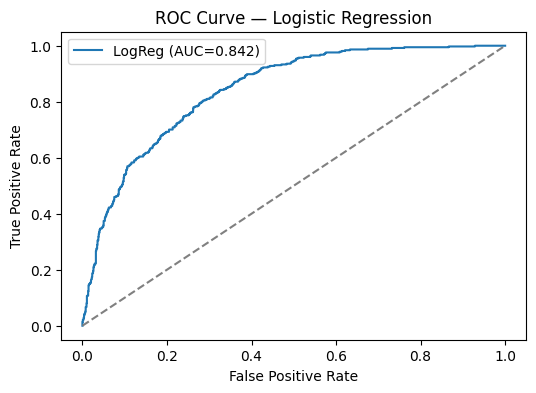

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Handle missing values properly ---

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

# --- Logistic Regression Pipeline ---

logit_clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# --- Fit and Evaluate ---
logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
y_proba = logit_clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"✅ Logistic Regression trained successfully")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")

# --- Plot ROC Curve ---
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogReg (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()


,Decile,Customers% (Cum),Responses% (Cum),Lift (Cum)
0,1,10.01,28.07,2.805
1,2,20.01,49.73,2.485
2,3,30.02,64.97,2.164
3,4,40.03,78.07,1.950
4,5,50.04,87.17,1.742
5,6,60.04,93.32,1.554
6,7,70.05,97.59,1.393
7,8,80.06,98.93,1.236
8,9,90.06,99.47,1.104
9,10,100.00,100.00,1.000


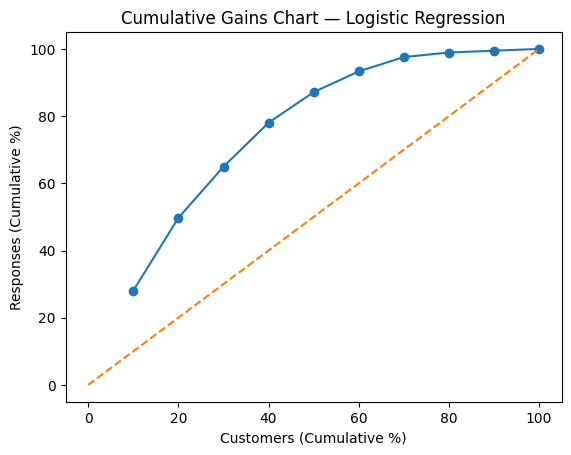

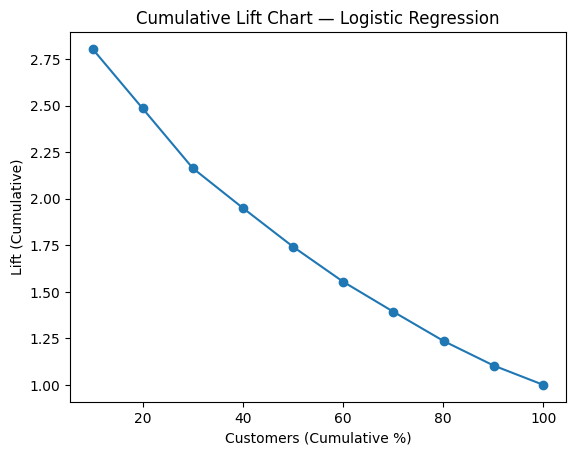

In [26]:

def compute_lift_gains(y_true, y_score, n_bins=10):
    order = np.argsort(-y_score)
    y_true = np.array(y_true)[order]
    y_score = np.array(y_score)[order]

    total_positives = y_true.sum()
    total = len(y_true)
    bins = np.array_split(np.arange(total), n_bins)

    records = []
    cumulative_hits = 0
    cumulative_perc_customers = 0
    for i, idx in enumerate(bins, start=1):
        hits = y_true[idx].sum()
        cumulative_hits += hits
        perc_customers = len(idx) / total
        cumulative_perc_customers += perc_customers
        cumulative_recall = cumulative_hits / total_positives if total_positives > 0 else 0
        baseline = cumulative_perc_customers
        lift = (cumulative_recall / baseline) if baseline > 0 else np.nan
        records.append({
            "Decile": i,
            "Customers% (Cum)": round(cumulative_perc_customers*100,2),
            "Responses% (Cum)": round(cumulative_recall*100,2),
            "Lift (Cum)": round(lift, 3)
        })
    return pd.DataFrame(records)

lift_table = compute_lift_gains(y_test, y_proba, n_bins=10)
display(lift_table)

plt.figure()
plt.plot(lift_table["Customers% (Cum)"], lift_table["Responses% (Cum)"], marker='o')
plt.plot([0,100],[0,100], linestyle='--')
plt.xlabel("Customers (Cumulative %)")
plt.ylabel("Responses (Cumulative %)")
plt.title("Cumulative Gains Chart — Logistic Regression")
plt.show()

plt.figure()
plt.plot(lift_table["Customers% (Cum)"], lift_table["Lift (Cum)"], marker='o')
plt.xlabel("Customers (Cumulative %)")
plt.ylabel("Lift (Cumulative)")
plt.title("Cumulative Lift Chart — Logistic Regression")
plt.show()


In [27]:

os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/logreg_churn_pipeline.joblib"
from joblib import dump
dump(logit_clf, model_path)
print("Saved model to:", model_path)


Saved model to: artifacts/logreg_churn_pipeline.joblib


In [30]:
import joblib
import pandas as pd

# ✅ Save the trained model for deployment
os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/logreg_churn_pipeline.joblib"
joblib.dump(logit_clf, model_path)
print(f"✅ Model saved successfully → {model_path}")

# ✅ Load the model (simulating deployment)
loaded_model = joblib.load(model_path)

# ✅ Build the inference function
def predict_churn_proba(customer_dict):
    """
    Takes a dictionary of feature_name: value
    Returns churn probability (float)
    """
    input_df = pd.DataFrame([customer_dict])
    proba = loaded_model.predict_proba(input_df)[:, 1][0]
    pred = loaded_model.predict(input_df)[0]
    return round(float(proba), 4), int(pred)

# ✅ Example Input (based on Telco dataset columns)
example = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 5,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 75.35,
    "TotalCharges": 350.5
}

# ✅ Run inference
proba, pred = predict_churn_proba(example)
print(f"\n📊 Inference Result:")
print(f"Predicted Churn Probability: {proba}")
print(f"Predicted Class (1=Churn, 0=No Churn): {pred}")

# ✅ Appendix - Utilities
def print_columns():
    """
    Prints all feature columns expected by the model.
    Useful to build inference examples correctly.
    """
    columns = list(X_train.columns)
    print(f"\n🧾 Model expects {len(columns)} features:")
    for c in columns:
        print(" -", c)

# Run the utility function to show all feature names
print_columns()


✅ Model saved successfully → artifacts/logreg_churn_pipeline.joblib

📊 Inference Result:
Predicted Churn Probability: 0.8006
Predicted Class (1=Churn, 0=No Churn): 1

🧾 Model expects 19 features:
 - gender
 - SeniorCitizen
 - Partner
 - Dependents
 - tenure
 - PhoneService
 - MultipleLines
 - InternetService
 - OnlineSecurity
 - OnlineBackup
 - DeviceProtection
 - TechSupport
 - StreamingTV
 - StreamingMovies
 - Contract
 - PaperlessBilling
 - PaymentMethod
 - MonthlyCharges
 - TotalCharges
